In [8]:
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

# Set the GROQ_API_KEY from the environment
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

# Check if the API key is loaded
if not os.environ.get("GROQ_API_KEY"):
    raise ValueError("GROQ_API_KEY not found. Please set it in your .env file.")

print("✅ API Key loaded successfully.")


✅ API Key loaded successfully.


In [9]:
from typing import TypedDict, Annotated, List, Optional
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

# Initialize the search tool
search_tool = DuckDuckGoSearchRun()
print(f"✅ Search tool initialized.")

# Define the state for our graph
# We now use `add_messages` to manage a continuous conversation history.
class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        messages: The list of messages that constitute the conversation history.
        research_material: The raw data gathered by the research agent.
        draft: The blog post draft written by the drafting agent.
        review_feedback: Feedback from the review agent on the draft.
        final_blog: The final, human-approved blog post.
    """
    messages: Annotated[List[BaseMessage], add_messages]
    research_material: Optional[str]
    draft: Optional[str]
    review_feedback: Optional[str]
    final_blog: Optional[str]


✅ Search tool initialized.


In [18]:
from langchain_groq import ChatGroq
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
import time
import json

# Initialize the LLM
llm = ChatGroq(model="llama3-70b-8192", temperature=0)

def intent_agent(state: GraphState):
    """
    Decides if the user's latest message is a blog request.
    """
    print("--- NODE: Intent Agent ---")
    messages = state['messages']
    
    system_prompt = SystemMessage(content="""
    You are a classification expert. Your task is to determine if the user's latest prompt
    is a request to write a blog post or if it is some other type of query.
    Respond with a JSON object containing one key: 'is_blog_request' (boolean).
    """)
    
    # We only pass the last message to the intent agent
    response = llm.invoke([system_prompt, messages[-1]])
    decision = json.loads(response.content)
    
    # This is a "silent" update to the state, not a message
    return {"is_blog_request": decision['is_blog_request']}

def chat_agent(state: GraphState):
    """
    Handles conversational queries.
    """
    print("--- NODE: Chat Agent ---")
    messages = state['messages']
    
    system_prompt = SystemMessage(content="You are a helpful assistant. Please provide a friendly and concise response to the user's query.")
    
    response = llm.invoke([system_prompt] + messages)
    
    print("✅ Generated conversational response.")
    # We add the AI's response to the message history
    return {"messages": [AIMessage(content=response.content)]}

def human_chat_input_node(state: GraphState):
    """
    Pauses the graph to get the next message from the user during a chat.
    """
    print("--- NODE: Human Chat Input ---")
    # The new message from the user is added to the history
    new_message = input("You: ")
    return {"messages": [HumanMessage(content=new_message)]}

def research_agent(state: GraphState):
    print("--- NODE: Research Agent ---")
    # The topic is now the content of the last human message
    topic = state['messages'][-1].content
    
    system_prompt = SystemMessage(content="You are a world-class research assistant...")
    search_results = search_tool.run(topic)
    task_prompt = HumanMessage(content=f"Please research the following topic: {topic}\n\nSearch Results:\n{search_results}")
    response = llm.invoke([system_prompt, task_prompt])
    
    print(f"✅ Research complete for topic: {topic}")
    return {"research_material": response.content}

def draft_agent(state: GraphState):
    print("--- NODE: Draft Agent ---")
    topic = state['messages'][-1].content
    research_material = state['research_material']
    
    system_prompt = SystemMessage(content="You are an expert blog post writer...")
    task_prompt = HumanMessage(content=f"Please write a blog post on the topic: '{topic}' using the following research:\n{research_material}")
    response = llm.invoke([system_prompt, task_prompt])
    
    print("✅ Blog draft completed.")
    # We add the draft as an AI message to keep the history clean
    return {"messages": [AIMessage(content=response.content)], "draft": response.content}

def review_agent(state: GraphState):
    print("--- NODE: Review Agent ---")
    draft = state['draft']
    system_prompt = SystemMessage(content="You are a meticulous editor...")
    task_prompt = HumanMessage(content=f"Please review the following blog post draft:\n\n{draft}")
    response = llm.invoke([system_prompt, task_prompt])
    
    print("✅ Review completed.")
    return {"review_feedback": response.content}

def print_boxed(title, content):
    box_width = 80
    print("\n" + "╔" + "═" * (box_width - 2) + "╗")
    title_line = f"║ 📄 {title.upper()} "
    print(title_line + " " * (box_width - len(title_line) - 1) + "║")
    print("╠" + "═" * (box_width - 2) + "╣")
    lines = content.split('\n'); [print(f"║ {l:<{box_width - 4}} ║") for l in lines]
    print("╚" + "═" * (box_width - 2) + "╝" + "\n")

def human_approval_node(state: GraphState):
    print("--- NODE: Human Blog Approval ---")
    draft = state['draft']
    review_feedback = state['review_feedback']
    print_boxed("Blog Draft for Your Review", draft)
    print_boxed("Reviewer's Feedback", review_feedback)
    
    while True:
        feedback = input("🤔 Approve the draft? (yes/no): ").strip().lower()
        if feedback in ["yes", "y"]:
            return {"messages": [HumanMessage(content="I approve this draft.")]}
        elif feedback in ["no", "n"]:
            notes = input("Please provide your revision notes: ")
            return {"messages": [HumanMessage(content=f"I do not approve. Revisions: {notes}")]}
        else:
            print("Invalid input.")


In [19]:
END = "end"

def route_after_intent(state: GraphState):
    """
    Router that decides the path based on the initial intent classification.
    """
    print("--- CONDITIONAL EDGE: Routing based on initial intent ---")
    if state.get("is_blog_request"):
        print("Decision: Proceeding with blog generation workflow.")
        return "research_agent"
    else:
        print("Decision: It's a conversational query. Routing to chat agent.")
        return "chat_agent"

def route_after_chat(state: GraphState):
    """
    Router that decides what to do after the user provides input in the chat loop.
    It checks if the user wants to generate a blog, end the conversation, or continue chatting.
    """
    print("--- CONDITIONAL EDGE: Routing based on chat input ---")
    last_message = state['messages'][-1].content.lower()
    
    if "generate a blog" in last_message or "write a blog" in last_message:
        print("Decision: User requested blog generation. Transitioning.")
        return "research_agent"
    elif "exit" in last_message or "quit" in last_message or "end" in last_message:
        print("Decision: User requested to end the conversation.")
        return END
    else:
        print("Decision: Continuing chat.")
        return "chat_agent"

def should_redraft(state: GraphState):
    """
    Determines if a redraft is needed based on human feedback on the blog.
    """
    print("--- CONDITIONAL EDGE: Checking for blog revisions ---")
    last_message = state['messages'][-1].content.lower()
    if "i approve" in last_message:
        print("Decision: Blog approved. Ending process.")
        return END
    else:
        print("Decision: Revisions needed. Looping back to draft agent.")
        return "draft_agent"


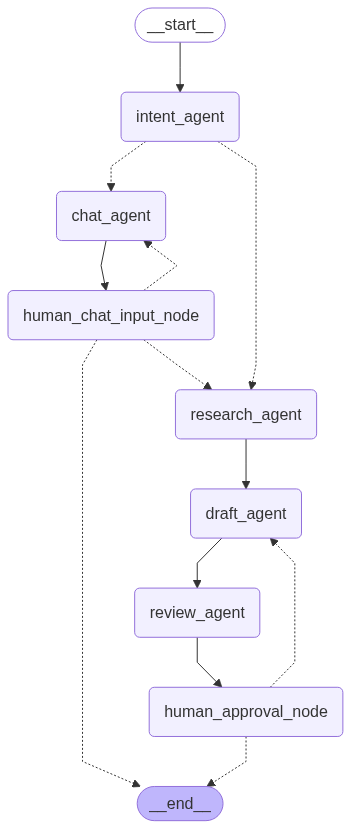

In [20]:
from langgraph.graph import StateGraph, END
from IPython.display import Image, display

# Initialize a new state graph
workflow = StateGraph(GraphState)

# Add all the nodes to the graph
workflow.add_node("intent_agent", intent_agent)
workflow.add_node("chat_agent", chat_agent)
# This new node will handle getting user input during a chat
workflow.add_node("human_chat_input_node", human_chat_input_node) 
workflow.add_node("research_agent", research_agent)
workflow.add_node("draft_agent", draft_agent)
workflow.add_node("review_agent", review_agent)
workflow.add_node("human_approval_node", human_approval_node)

# Set the initial entry point
workflow.set_entry_point("intent_agent")

# This router decides whether to start the blog workflow or enter the chat loop
workflow.add_conditional_edges(
    "intent_agent",
    route_after_intent,
    {
        "research_agent": "research_agent",
        "chat_agent": "chat_agent" # If it's a chat, go to the chat agent first
    }
)

# The chat agent will now lead to a human input node, creating a loop
workflow.add_edge("chat_agent", "human_chat_input_node")

# After the human provides input in the chat, we need to decide what to do next
workflow.add_conditional_edges(
    "human_chat_input_node",
    route_after_chat, # This new router will check the user's latest message
    {
        "chat_agent": "chat_agent", # Loop back to the chat agent
        "research_agent": "research_agent", # Transition to the blog workflow
        END: END # End the conversation
    }
)

# This is the original blog generation workflow, which remains the same
workflow.add_edge("research_agent", "draft_agent")
workflow.add_edge("draft_agent", "review_agent")
workflow.add_edge("review_agent", "human_approval_node")

# This is the original human approval loop for the blog draft
workflow.add_conditional_edges(
    "human_approval_node",
    should_redraft,
    {
        "draft_agent": "draft_agent",
        END: END
    }
)

# Compile the graph into a runnable app
app = workflow.compile()

# Display the graph structure to verify it
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}. Please ensure pygraphviz and its dependencies are installed.")

In [ ]:
import json
from langgraph.graph import END
from langchain_core.messages import HumanMessage, AIMessage

# Get the initial topic from the user
initial_prompt = input("Hello! What can I help you with today? (Type 'exit' or 'quit' to end) ")

# Prepare the initial state as a list of messages
messages = [HumanMessage(content=initial_prompt)]
config = {"recursion_limit": 150}
final_state = None

# This loop will continue until the user types 'exit' or the blog is generated
while True:
    if "exit" in messages[-1].content.lower() or "quit" in messages[-1].content.lower():
        print("Exiting conversation.")
        break

    # Use stream to get events from the graph as they happen
    for event in app.stream({"messages": messages}, config=config):
        for node_name, state_update in event.items():
            print(f"\n--- Event: Finished '{node_name}' ---")
            
            # If the chat agent just ran, print its response immediately
            if node_name == 'chat_agent' and 'messages' in state_update:
                ai_response = state_update['messages'][-1]
                if isinstance(ai_response, AIMessage):
                    print(f"Assistant: {ai_response.content}")
            
            # Check if the graph has reached a final state
            if node_name == END:
                final_state = state_update
                break
    else: 
        # This 'else' block runs if the 'for' loop completes without hitting a 'break'.
        # This means the graph has paused waiting for human input.
        next_prompt = input("You: ")
        messages.append(HumanMessage(content=next_prompt))
        continue # Go to the next iteration of the while loop

    # If the 'for' loop was broken (meaning the graph hit an END state), 
    # we break the 'while' loop as well.
    break

print("\n" + "🎉"*20)
print("Process Complete!")
print("🎉"*20 + "\n")

# Use the final state captured when the graph ended
if final_state and final_state.get("draft"): # Using draft as a proxy for blog generation
    print_boxed("Final Blog Post", final_state['draft'])
else:
    print("Thank you for chatting!")


--- NODE: Intent Agent ---
--- CONDITIONAL EDGE: Routing based on initial intent ---
Decision: It's a conversational query. Routing to chat agent.

--- Event: Finished 'intent_agent' ---
--- NODE: Chat Agent ---
✅ Generated conversational response.

--- Event: Finished 'chat_agent' ---
Assistant: Hi! It's nice to meet you. Is there something I can help you with or would you like to chat?
--- NODE: Human Chat Input ---
--- CONDITIONAL EDGE: Routing based on chat input ---
Decision: User requested blog generation. Transitioning.

--- Event: Finished 'human_chat_input_node' ---
--- NODE: Research Agent ---


/home/nikhil/learning/agentic_ai/workspace/venv/lib/python3.12/site-packages/langchain_community/utilities/duckduckgo_search.py:63: RuntimeWarning: This package (`duckduckgo_search`) has been renamed to `ddgs`! Use `pip install ddgs` instead.
  with DDGS() as ddgs:


✅ Research complete for topic: can you write a blog about gt6

--- Event: Finished 'research_agent' ---
--- NODE: Draft Agent ---
✅ Blog draft completed.

--- Event: Finished 'draft_agent' ---
--- NODE: Review Agent ---
✅ Review completed.

--- Event: Finished 'review_agent' ---
--- NODE: Human Blog Approval ---

╔══════════════════════════════════════════════════════════════════════════════╗
║ 📄 BLOG DRAFT FOR YOUR REVIEW                                                 ║
╠══════════════════════════════════════════════════════════════════════════════╣
║ Here is the blog post on Gran Turismo 6:                                     ║
║                                                                              ║
║ **Getting Behind the Wheel: A Review of Gran Turismo 6**                     ║
║                                                                              ║
║ **Introduction:**                                                            ║
║                                    